# Out-of-the-📦 FP8 Training

This notebook demonstrates how the `unit_scaling` library can be used to easily adapt a model to train in FP8.

💻 **Try the library**: [graphcore-research.github.io/unit-scaling](https://graphcore-research.github.io/unit-scaling/)

📖 **Read the paper**: [Unit Scaling: Out-of-the-Box Low-Precision Training](https://arxiv.org/abs/2303.11257)

In [ ]:
# Setup
%pip install -r requirements.txt

## TL;DR

Naïvely casting to FP8 causes training to fail as some values go out-of-range.
This can be fixed simply by using unit-scaled layers.

`unit_scaling` provides a transform to automatically unit-scale models (and another to simulate FP8 matmuls). We apply this to Andrej Karpathy's [NanoGPT](https://github.com/karpathy/nanoGPT) model:

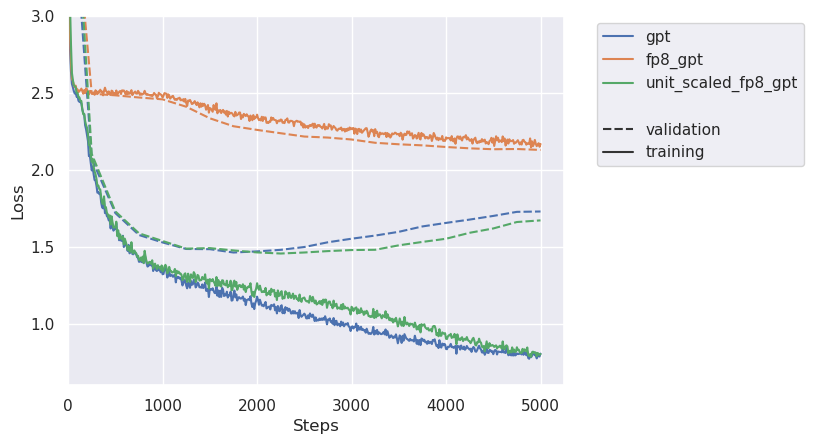

In [ ]:
from nanoGPT.model import GPT
from notebook_utils import config, train
from unit_scaling.transforms import simulate_fp8, unit_scale

gpt = GPT(config)  # model unchanged from original nanoGPT
fp8_gpt = simulate_fp8(gpt)
unit_scaled_fp8_gpt = unit_scale(fp8_gpt)

models = [gpt, fp8_gpt, unit_scaled_fp8_gpt]
for model in models:
    train(model)

We see that training the base model directly in FP8 causes a significant degradation. Full accuracy can then be recovered by using unit-scaled layers.

This transform can be applied to arbitrary PyTorch models, with negligible overhead when used with `torch.compile`†. For users who don't wish to use the automatic transform, unit scaling can also be implemented manually‡.

What follows is a step-by-step guide on the problem of naïvely running in FP8, and how `unit_scaling` addresses it.

†_See our [Benchmarking Compiled Unit-Scaled Ops](https://github.com/graphcore-research/unit-scaling/blob/main/analysis/benchmarking_compiled_unit_scaled_ops.ipynb) notebook for a full analysis of the (lack of) overhead when using `unit_scaling`. Note that `torch.compile` does not yet support our `simulate_fp8` transform, so we don't use compilation for this demo._

‡_See the [User Guide](https://graphcore-research.github.io/unit-scaling/user_guide) for details on how to manually implement unit scaling. This largely consists of swapping regular PyTorch modules and functions for their unit-scaled equivalents in the library._

---

## Why use FP8?

Floating point numbers comprise three parts: a sign bit, exponent bits (providing range) and mantissa bits (providing precision). Initial deep learning models used 32-bit floating-point representations (FP32), later shifting to 16-bits (FP16/BF16) for most operations to improve efficiency.

Two standards have recently been proposed for 8-bit floating-point formats ([1](https://www.graphcore.ai/posts/graphcore-and-amd-propose-8-bit-fp-ai-standard-with-qualcomm-support),[2](https://developer.nvidia.com/blog/nvidia-arm-and-intel-publish-fp8-specification-for-standardization-as-an-interchange-format-for-ai/)), both of which use a 4-bit exponent version (FP8 E4) for activations and weights, and a 5-bit exponent version (FP8 E5) for gradients. The latest generation of deep learning accelerators (such as Graphcore's [C600](https://www.graphcore.ai/products/c600) or Nvidia's [H100](https://www.nvidia.com/en-gb/data-center/h100/)) provide specialised hardware to accelerate FP8 matrix-multiplications, typically giving double the FLOP/s of 16-bit formats.

Research ([3](https://arxiv.org/abs/2206.02915),[4](https://arxiv.org/abs/2209.05433)) has shown that it's possible to train using FP8 matmuls without degradation. However, the obvious approach of inserting a cast before each matmul is not sufficient.

(For a more detailed overview of different number formats, see [this visualisation](https://thecharlieblake.co.uk/visualising-ml-number-formats))

## The problem with naïve FP8 training

We'll demonstrate this problem using Andrej Karpathy's popular [NanoGPT](https://github.com/karpathy/nanoGPT) model. We simulate the use of FP8 here via the `simulate_fp8()` wrapper provided by `unit_scaling.transforms`. This identifies every matmul in the forward and backward passes and quantises them to the representable values in the appropriate FP8 format.

Note that we use *simulated* FP8 here rather than relying on FP8 hardware, as this notebook is intended as a demo. The `unit_scaling` library does not yet contain cast operations that run on FP8 hardware, so for now we keep tensors in higher precision, rounding values to those provided by FP8 without actually changing the underlying data type.

Let's now train the original FP32 GPT model, alongside a second model which inserts these "naïve" FP8 casts:

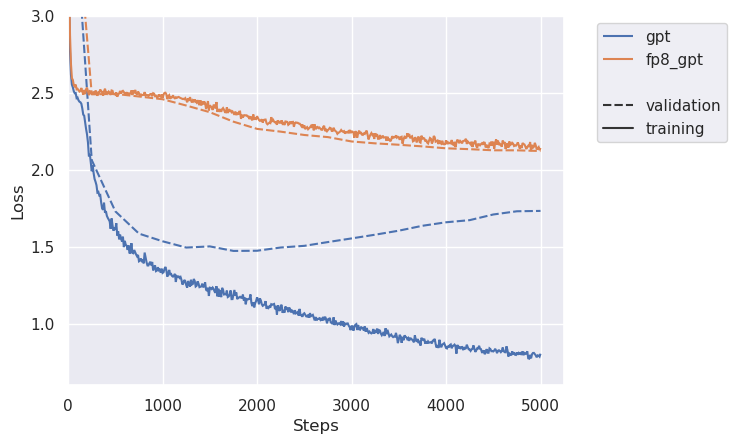

In [ ]:
from nanoGPT.model import GPT
from notebook_utils import config, train
from unit_scaling.transforms import simulate_fp8

gpt = GPT(config)  # model unchanged from original nanoGPT
fp8_gpt = simulate_fp8(gpt)

models = [gpt, fp8_gpt]
for model in models:
    train(model)

We can see that simply inserting FP8 casts before matmuls causes a significant degradation. Why is this the case, and how can we do better?

To answer these questions the `unit_scaling` library provides a `visualiser` tool, designed to facilitate the analysis of scale within models. It uses the PyTorch 2.0 [TorchDynamo compiler](https://pytorch.org/docs/stable/dynamo/index.html) to capture the model-graph, which is then visualised in terms of the scale of each tensor.

By running the visualiser on the (untrained) base model, the problem with these FP8 casts becomes evident:

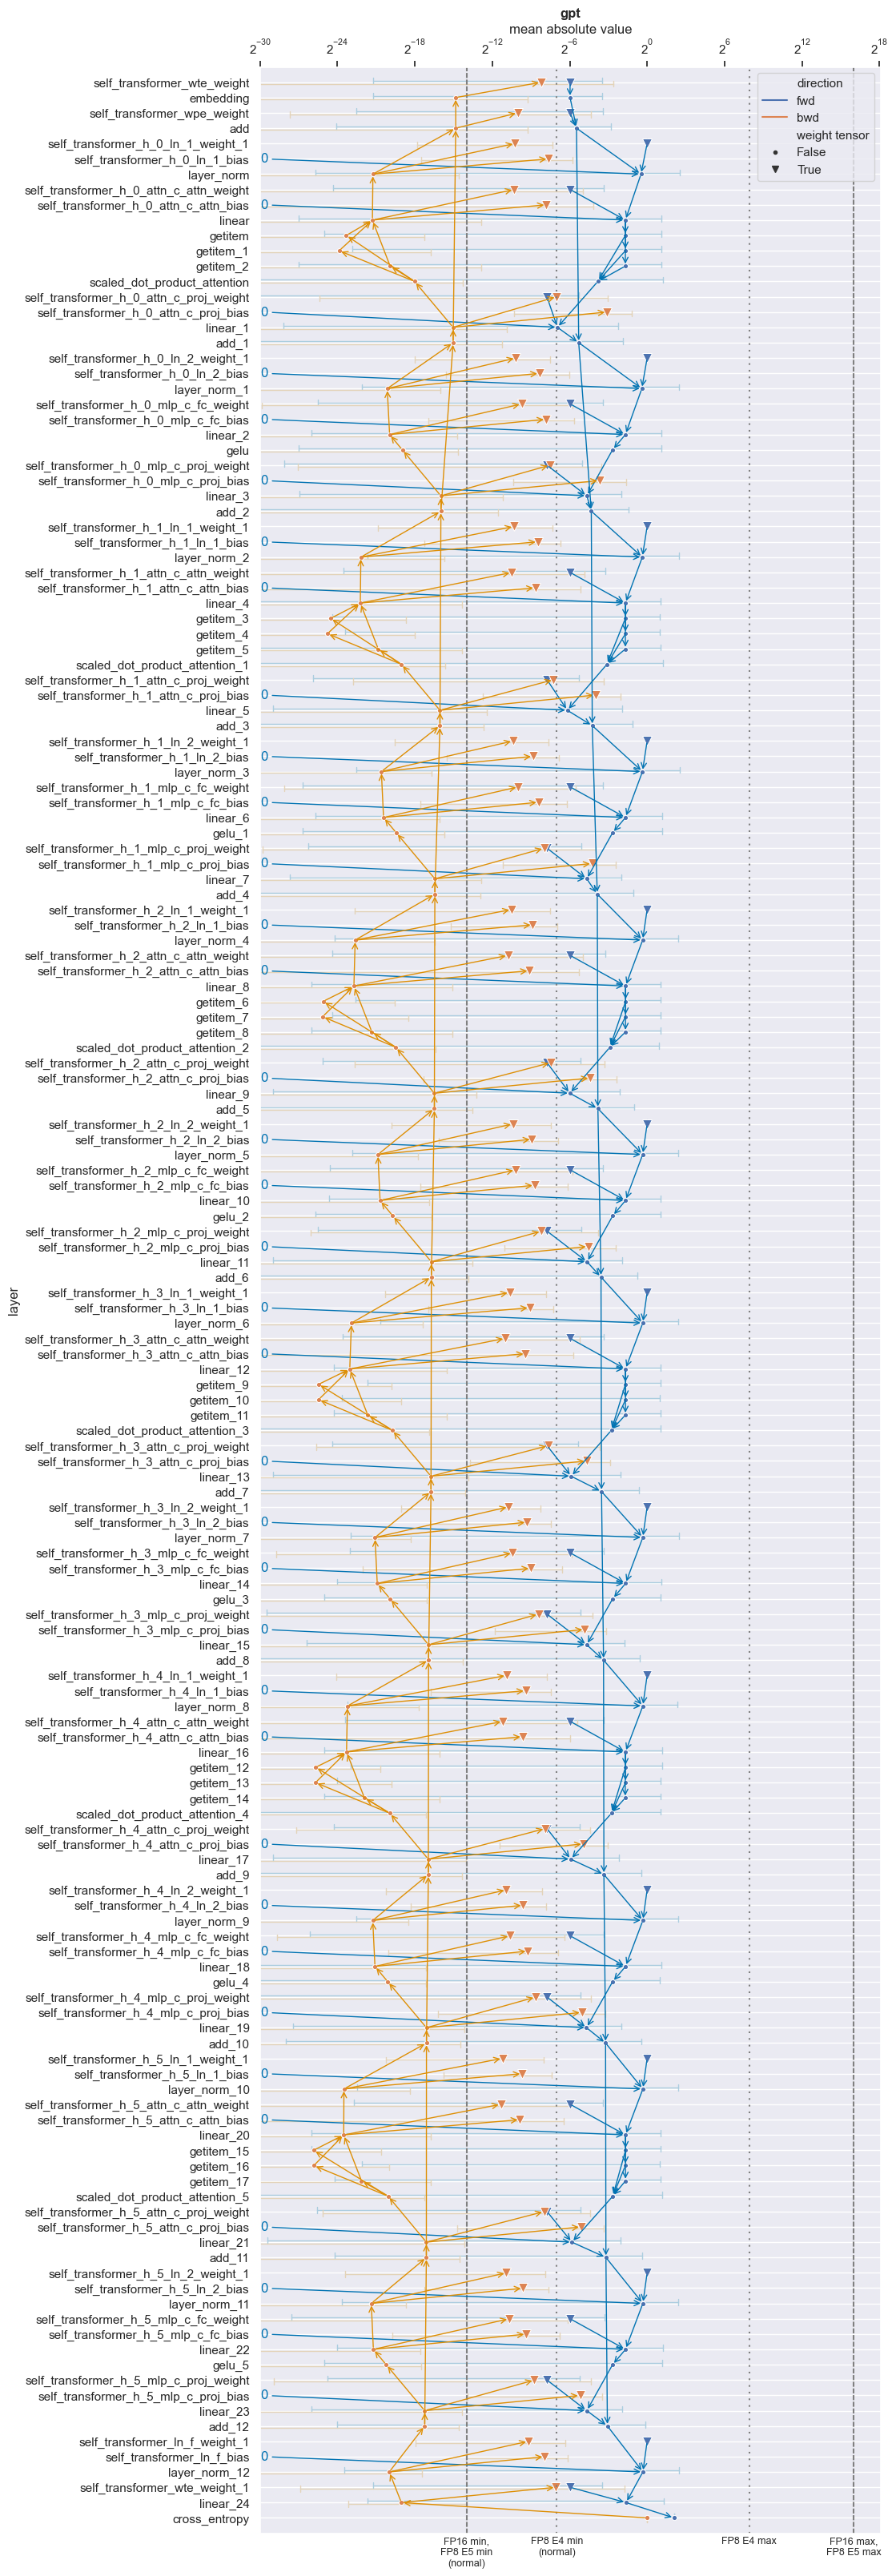

In [2]:
from unit_scaling import visualiser
from notebook_utils import config, NanoGPTTokenizer

visualiser(
    model=GPT(config),
    tokenizer=NanoGPTTokenizer(),
    batch_size=config.batch_size,
    seq_len=config.block_size,
    title="gpt",
    xmin=2**-30,
)

> **Interpreting the visualisation:** The above plot represents the model's computational graph. Each row indicates an operation. Blue arrows denote tensors in the forward pass and orange arrows denote tensors in the backward pass. The connections between operations indicate that the output of one operation is the input to another. Faint horizontal bars show the minimum and maximum values in each tensor.
>
> The location of each tensor on the x-axis indicates the mean absolute value†. Dotted vertical lines highlight the maximum/minimum values for the different FP8 formats, recalling that E4 is used for activations and weights and E5 for gradients.
> 
>  Note that whereas the maximum values for floating-point formats have a hard cut-off, the minimum values have an additional *subnormal* range where values can still be represented, but at increasingly low precision. These aren't shown on the above plot for the sake of clarity. For FP8 the additional range provided is fairly small: E5 minimum subnormal = 2^-17, E4 minimum subnormal = 2^-10. FP32 is also not shown as its range is significantly larger.

We see that values in both the forward and the backward pass stray outside of the safe ranges of their FP8 formats. Some gradient tensors are small enough to be entirely zeroed out when cast straight to FP8; hence why performance of the naïve FP8 model was so poor.

It's worth emphasising that this visualisation shows the model at initialisation. Once training begins tensor scales are likely to shift, potentially moving additional values outside the bounds of their formats.

From a numerical perspective, we'd ideally want the tensor scales of our models at initialisation to be aligned in the centre of our range, equidistant from the upper and lower boundaries‡. Then as scales begin to shift during training, we have maximal headroom in either direction.

But standard deep learning layers are not designed to satisfy this property. We see from the above plot that many operations cause significant scale shifts for both activations and gradients, making models hard to quantise.

The question thus arises: **can we re-scale our operations to ensure that models have unit scale at initialisation?**

This is the premise of unit scaling.

†*The theoretical analysis underlying unit scaling is based on the standard deviation at initialisation, rather than the mean absolute value. However, most tensors in initialised models are zero-mean and normally-distributed, in which case the mean absolute value is very similar (~= 0.8σ). Users have found this measure to be more easily interpretable, so we use it as the default in `visualiser`, but the `metric='std'` option can be used instead.*

‡*You could argue for a slightly different optimal scale on the basis of subnormal values, the relative damage caused by underflow vs overflow or scaling for standard deviation versus mean-absolute-value. We argue in the paper that given these concerns, aiming for unit variance is perhaps a sensible compromise.*

## The solution: unit scaling

Unit scaling is a technique that aims to ensure the unit variance of all weights, activations and gradients at the beginning of training, centring values in the middle of the numerical range. This is done by introducing scaling factors (scalar multiplications) after individual operations, to ensure that each maintains this scale-preserving property.

As a consequence, using low-precision number formats (for example FP8) becomes straightforward — simply insert a cast operation, no additional tricks required.

The scaling factors are derived via a theoretical analysis of each operation's effect on its input's standard deviation. This has the benefit of not requiring empirical run-time analysis of tensor scales. Instead we are able to determine scales as a function of tensor shapes, allowing us to define our own _unit-scaled_ versions of common operations, with minimal overhead — we don't have to compute standard deviations of all our tensors to derive scales.

The core of the `unit_scaling` library is a catalogue of these re-scaled operations. To demonstrate, the following is the (slightly simplified) implementation of our `unit_scaling.functional.linear` function (our equivalent of `torch.nn.functional.linear`):

```python
from unit_scaling.scale import scale_bwd, scale_fwd

def linear(x: Tensor, weight: Tensor, bias: Tensor) -> Tensor:
    fan_out, fan_in = weight.shape
    batch_size = x.numel() // fan_in

    output_scale = fan_in**-0.5
    grad_input_scale = fan_out**-0.5
    grad_weight_scale = grad_bias_scale = batch_size**-0.75
    
    output_scale = grad_input_scale = geometric_mean(output_scale, grad_input_scale)

    x = scale_bwd(x, grad_input_scale)  # i.e. x * grad_input_scale, but only in the bwd pass
    weight = scale_bwd(weight, grad_weight_scale)
    bias = scale_bwd(bias, grad_bias_scale)

    output = torch.nn.functional.linear(x, weight, bias)
    
    return scale_fwd(output, output_scale)
```

Our implementation wraps the original PyTorch call with `scale_fwd` and `scale_bwd` functions, which insert scaling factors into the forward and backward passes. In some cases, we have to use the same scale for the forward and backward passes to generate valid gradients, necessitating the `geometric_mean`; in other cases (for example `grad_weight_scale`) we can use different scales (see [the paper](https://arxiv.org/abs/2303.11257) for more detail).

The key point here is that unit scaling provides simple and low-overhead rules for re-scaling common operations. It should be noted that unit scaling is not simply a "way of running" an existing model. Unit scaled models are fundamentally different from their non-unit-scaled equivalents, though the difference is minor (largely relating to scales going into non-linear and residual operations). This is reflected in the slightly altered shape of our training curves. We emphasise that in our experiments — unit scaled models are neither consistently better or worse than non-unit-scaled ones.

Implementing unit scaling using the library is thus fairly straightforward, mostly consisting of swapping regular layers for their unit-scaled equivalents. Consider the following common approach to importing PyTorch modules/functions:

```python
from torch import nn
from torch import functional as F
```

In this setting unit scaling can be applied by first adding:

```python
import unit_scaling as uu
from unit_scaling import functional as U
```

and then replacing the letters `nn` with `uu` and `F` with `U`, for those classes and functions to be unit scaled. For example:

```python
class UnitScaledMLP(nn.Module):
    def __init__(self, d: int) -> None:
        super().__init__()
        self.linear_1 = uu.Linear(d, d * 4)  # Changed `nn` to `uu`
        self.linear_2 = uu.Linear(d * 4, d)  # Changed `nn` to `uu`

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear_1(x)
        x = U.gelu(x)  # Changed `F` to `U`
        return self.linear_2(x)
```

There are a few additional considerations required to make unit scaling work properly, which are covered in our [User Guide](https://graphcore-research.github.io/unit-scaling/user_guide). Particular care should be taken to correctly scale skip/residual additions and loss functions.

We also provide a convenience method that aims to automatically unit-scale arbitrary PyTorch models: `unit_scaling.transforms.unit_scale`. This works by creating a `torch.fx` graph representation of the model and inserting the required operations. We use the PyTorch 2.0 [TorchDynamo compiler](https://pytorch.org/docs/stable/dynamo/index.html) to capture the model-graph, which we found to be a much more effective approach than previous PyTorch compilation techniques.

Nevertheless, for now this automatic transform should be considered experimental (we've only tested it on NanoGPT). We recommend most users implement unit scaling in the manual way outlined above.

With the unit scaling library in hand, let's revisit our scale visualisation. By applying the unit scaling transform to the base NanoGPT model, we are able to achieve the following:

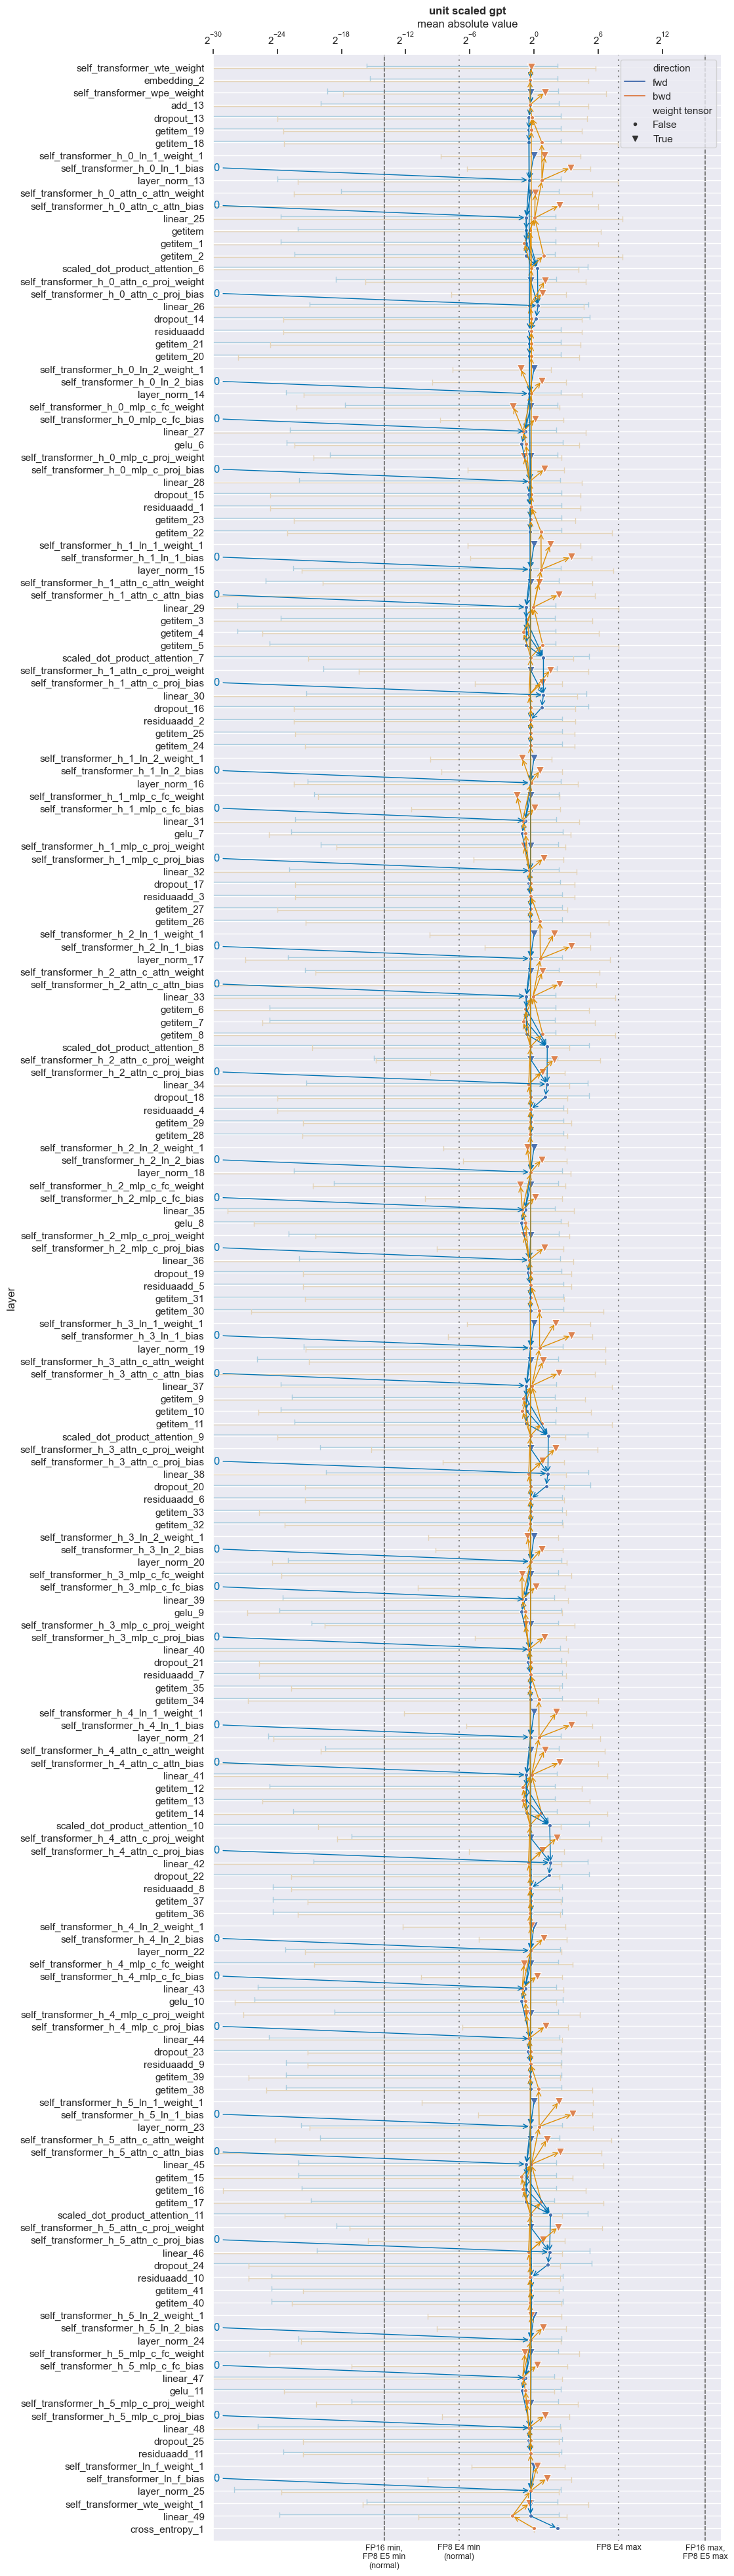

In [4]:
from unit_scaling.transforms import unit_scale

visualiser(
    model=unit_scale(GPT(config)),
    tokenizer=NanoGPTTokenizer(),
    batch_size=config.batch_size,
    seq_len=config.block_size,
    title="unit scaled gpt",
    xmin=2**-30,
)

The scale of tensors in both passes is much closer to the centre of the numerical range than in the original model. By swapping regular layers for unit-scaled ones we've made models that, at least at initialisation, can be cast to FP8 without issue.

What happens after initialisation? Let's now train our unit-scaled model in FP8 to see if values continue to stay in range during training. If so, we expect to get back to the performance of the original model (assuming that FP8 has sufficient precision).

We use exactly the same training regime and hyperparameters for our unit-scaled model, with the exception of the learning rate (which has been re-swept):

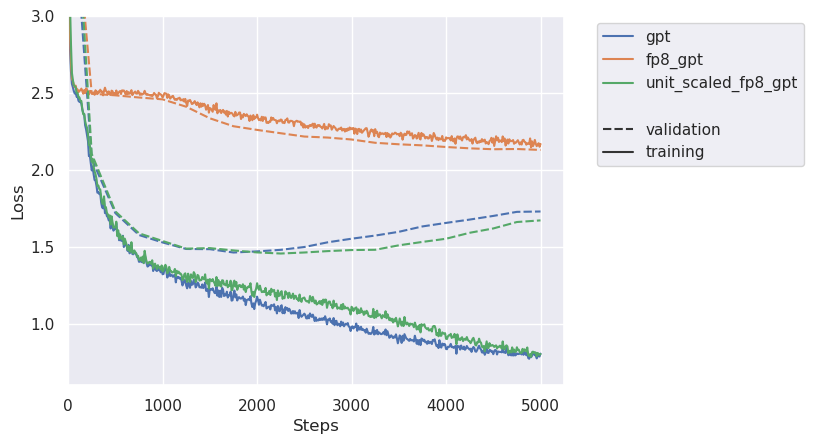

In [ ]:
unit_scaled_fp8_gpt = unit_scale(simulate_fp8(gpt))
train(unit_scaled_fp8_gpt, learning_rate=0.02, min_lr=0.002)

We see that both training and validation curves reach the level of the original NanoGPT model — a significant improvement over our initial attempt at FP8 training! As noted above, due to small model differences the shape of the curves is slightly different, but the model is just as good.

These results validate that unit scaling is able to give out-of-the-box FP8 training with no degradation, at least for this small NanoGPT model. In our paper, we show this also holds for BERT Large, and we hope in future to scale model size further.

Let's conclude by examining what's happened to our tensor scales as a result of training. This question is essential to understanding the success of unit scaling (and its potential to work on larger models). We apply our `visualiser` tool to the trained unit-scaled model to see how tensor scales have changed:

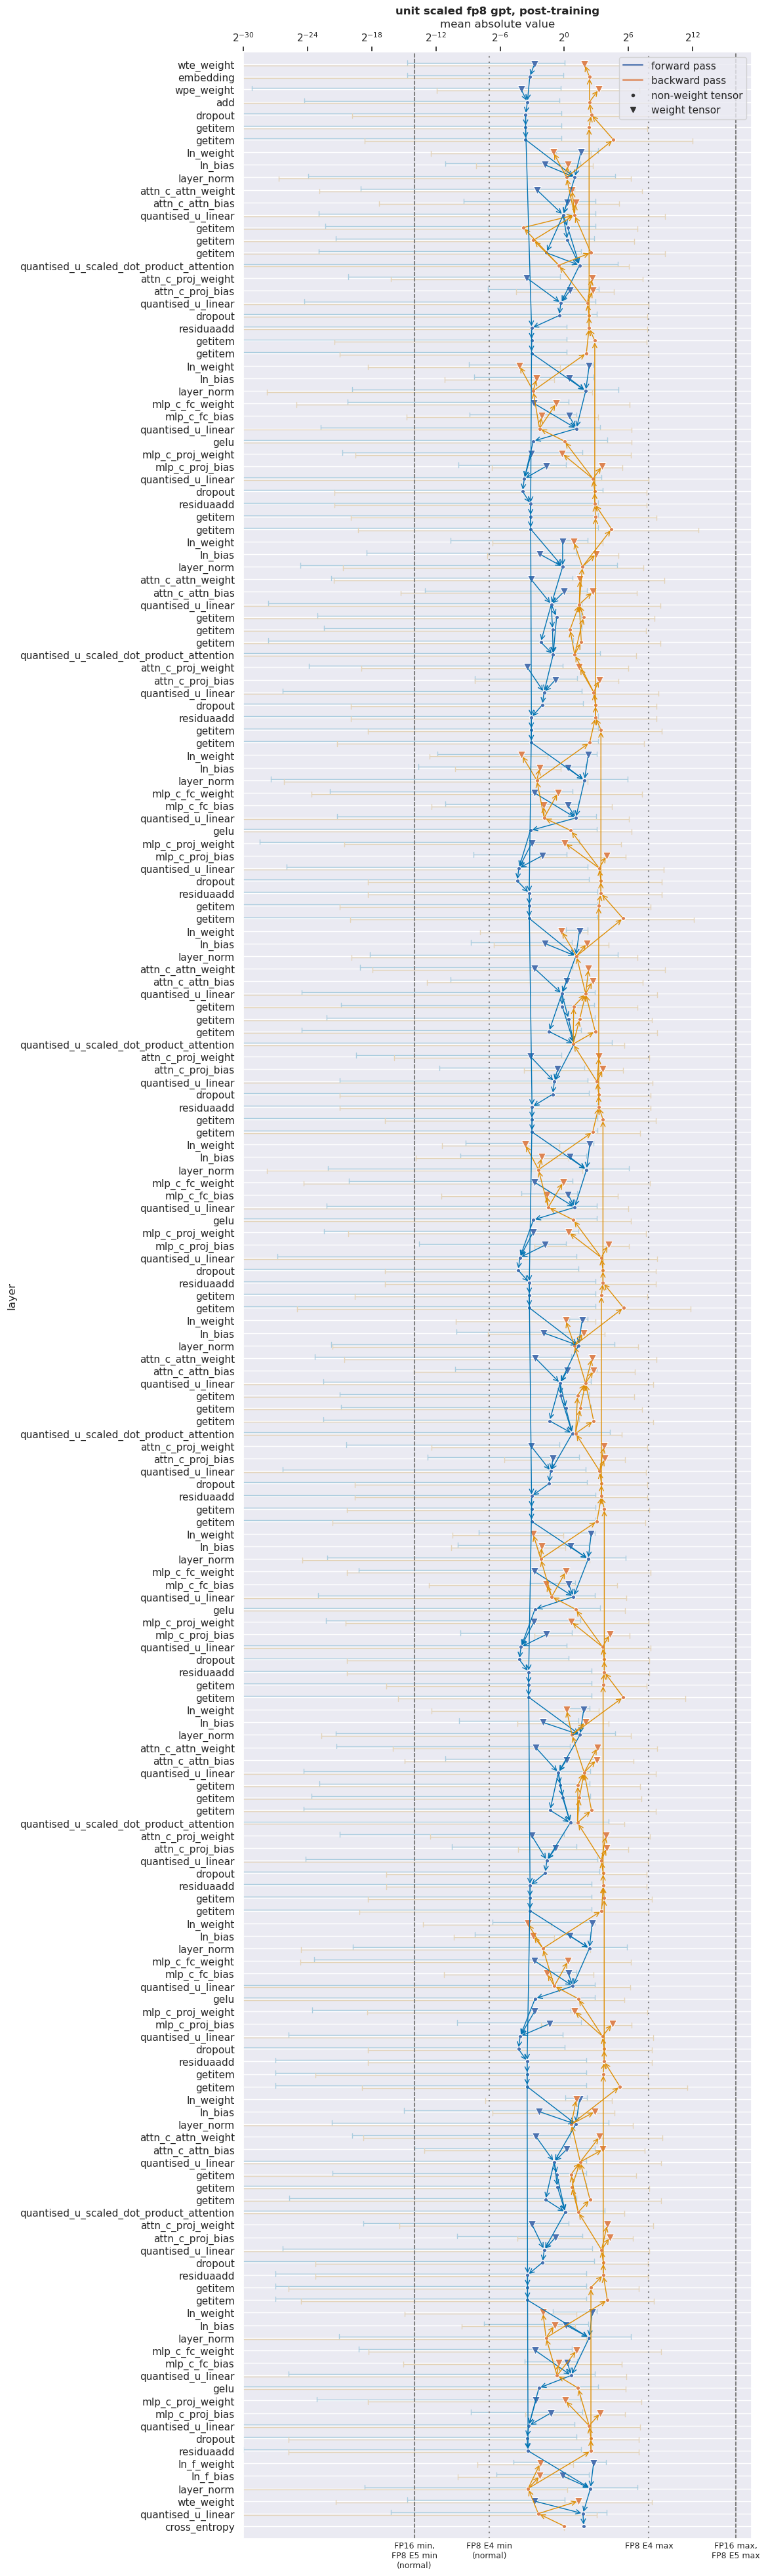

In [ ]:
visualiser(
    model=unit_scaled_fp8_gpt,
    tokenizer=NanoGPTTokenizer(),
    batch_size=config.batch_size,
    seq_len=config.block_size,
    title="unit scaled fp8 gpt, post-training",
    xmin=2**-30,
)

Activations have shrunk slightly with gradients increasing by a similar amount. Overall these shifts are not too substantial, and we're still comfortably within the range defined by our formats. This explains the success of unit scaling in enabling FP8 training.

Our paper covers alternative methods proposed for low-precision training, and highlights the way in which unit scaling makes a different set of trade-offs to other approaches. Particular benefits of unit scaling are its simplicity, low overheads and granularity. We hope that for many users it will provide the simplest and most effective approach to getting the most from their FP8 hardware.

## Trying out unit scaling

Unit scaling can be installed with:

In [ ]:
%pip install git+https://github.com/graphcore-research/unit-scaling.git

Head on over to our [documentation](https://graphcore-research.github.io/unit-scaling) to check out the API and get started. The library is designed to work cross-platform, so it should run on all hardware, for example CPUs, IPUs and GPUs.

`unit_scaling` is a new library and (despite our best efforts!) we can't guarantee it will be bug-free or feature-complete. We're keen to assist anyone who wants to use the library though, and help them work through any issues. We expect to spend the next few months jumping on feature requests, bug fixes, and generally helping out new users.

Known limitations of the library include:
- Op coverage: we've currently focussed on adding common transformer operations — other ops may be missing (though we can add most requested ops without difficulty)
- Using transforms with `torch.compile`: currently our transforms (for example `unit_scale`, `simulate_fp8`) can't be used with `torch.compile`. We provide a special compilation function to get around this: `unit_scaling.transforms.compile` (see docs for more details), though this only works with `unit_scale` and not `simulate_fp8`.
- Distributed training: although we suspect distributed training will still work reasonably well with the current library, we haven't tested this.

If you're trying out the library, we'd love to hear from you!

Please reach out through our community of developers using our [Slack channel](https://www.graphcore.ai/join-community) or raise a [GitHub issue](https://github.com/graphcore-research/unit-scaling).